## Utilisation des principes GitOps

Après avoir vu comment configurer un cluster Kubernetes, nous apprendrons comment le faire en utilisant Git Opspractices au lieu d'appliquer des commandes et des fichiers manuels. 

GitOps signifie gérer la configuration du cluster à l'aide d'un référentiel Git pour stocker et suivre les fichiers YAML qui contiennent la configuration. Nous verrons comment lier un repo GitHub à un cluster, afin qu'il soit mis à jour régulièrement, à l'aide de Flux. Cette méthode nous permet de stocker la configuration de manière déterministe, décrivant les changements d'infrastructure dans le code. Les modifications peuvent être revues et le cluster peut être récupéré à partir de zéro ou dupliqué.


Les sujets suivants seront traités dans ce guide : 

* Comprendre la description de GitOps 
* Configurer Flux pour contrôler le cluster Kubernetes 
* Configurer GitHub 
* Créer un changement de cluster Kubernetes via GitHub 
* Travailler en production 

À la fin du guide, vous saurez comment stocker la configuration Kubernetes dans un Gitrepository et appliquer automatiquement toutes les modifications fusionnées dans la branche principale.

## Comprendre la description de GitOps

Un gros problème traditionnel dans les opérations a été de s'assurer que les différents serveurs maintiennent une configuration appropriée. Lorsque vous disposez d'une flotte de serveurs, déployer un service et les maintenir correctement configurés n'est pas une tâche simple.


    Pour ce guide, nous utiliserons la configuration pour décrire un service et
    toute la configuration requise pour l'exécuter en production. Cela inclut
    la version particulière du service, mais également des éléments tels que
    l'infrastructure sous-jacente (version du système d'exploitation, nombre de
    serveurs, etc.) ou les packages et la configuration des services dépendants
    (équilibreurs de charge, bibliothèques tierces, etc.)


Garder la configuration sur la bonne voie dans tous les serveurs est un défi à mesure que l'infrastructure se développe. Le changement le plus courant consiste à déployer une nouvelle version d'un service, mais il existe d'autres possibilités. Par exemple, un nouveau serveur doit être ajouté à l'équilibreur de charge, de nouveaux réglages de configuration pour NGINX pour corriger un bogue de sécurité ou une nouvelle variable d'environnement pour le service pour activer une fonctionnalité. 

L'étape initiale est la configuration manuelle, mais cela devient difficile à faire après un certain temps.




## Gestion de la configuration

La configuration manuelle signifie qu'un membre de l'équipe garde une trace d'un petit nombre de serveurs et, lorsqu'un changement est requis, se connecte individuellement sur chaque serveur et apporte les modifications requises.


Ce mode de fonctionnement demande beaucoup de travail et est sujet aux erreurs avec plusieurs serveurs, car ils pourraient facilement diverger.

Ainsi, après un certain temps, il peut être amélioré grâce à certains scripts utilisant Fabric (http://www.fabfile.org/) ou Capistrano (https://capistranorb.com/). Le modèle de base est de pousser la configuration et le nouveau code vers les serveurs et d'effectuer un certain nombre de tâches automatisées, en redémarrant le service à la fin. En règle générale, cela se fait directement à partir des ordinateurs de l'équipe, en tant qu'étape manuelle

Certains éléments de maintenance du serveur, comme les mises à niveau du système d'exploitation ou la mise à jour des bibliothèques, peuvent encore nécessiter d'être effectués manuellement


Le diagramme suivant montre comment le code est poussé depuis l'ordinateur du membre de l'équipe qui effectue la modification de configuration :

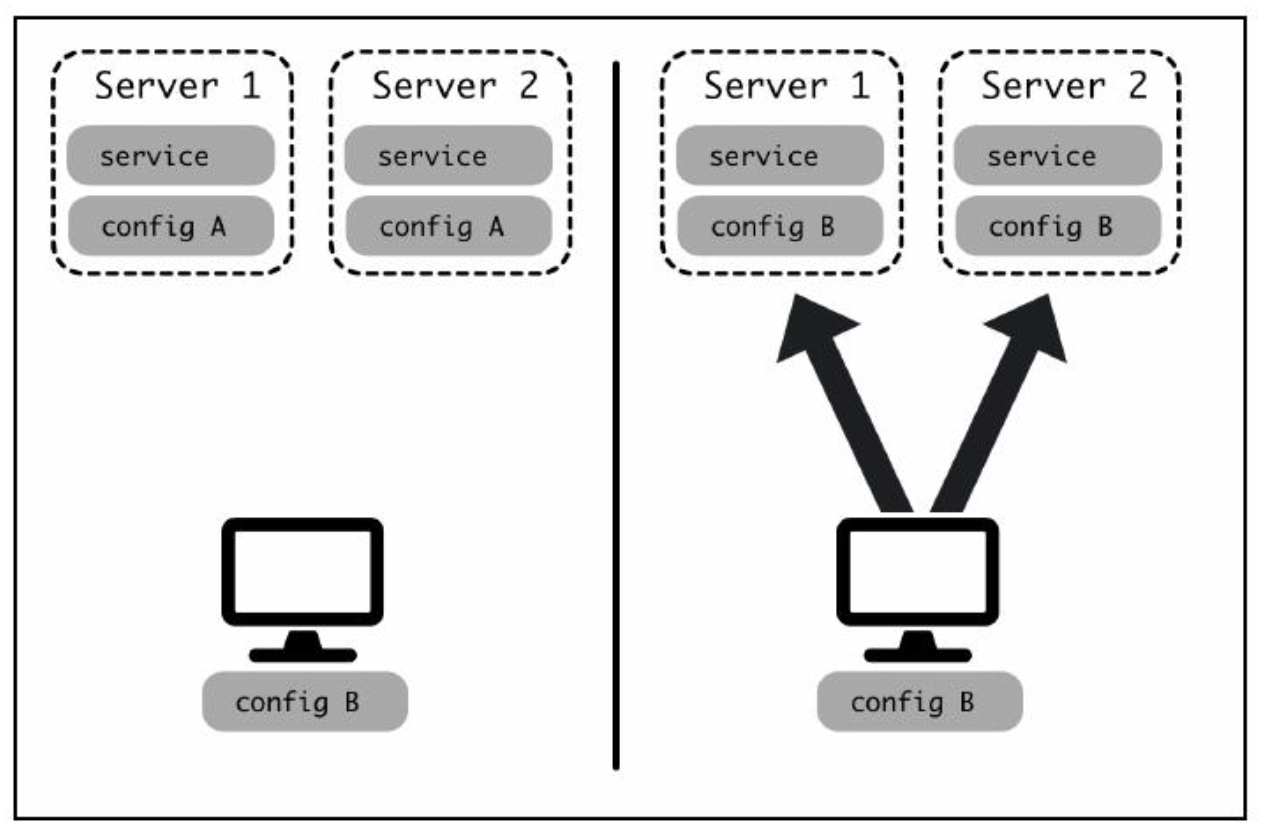

À ce stade, une nouvelle infrastructure peut être ajoutée manuellement ou en utilisant un outil tel que Terraform (https://www.terraform.io/ ) pour interagir avec les services cloud.

Une alternative plus sophistiquée consiste à utiliser des outils tels que Puppet (https://puppet.com ) ou Chef (https://www.chef.io/ ). Ils fonctionnent avec une architecture client-serveur. Ils nous permettent de décrire l'état des serveurs en utilisant leur propre langage déclaratif, et lorsque cela est modifié dans le serveur, tous les clients se mettent à jour pour suivre la définition. Le serveur signalera tout problème ou écart et centralisera la définition de la configuration


Ce processus est résumé dans le schéma suivant :

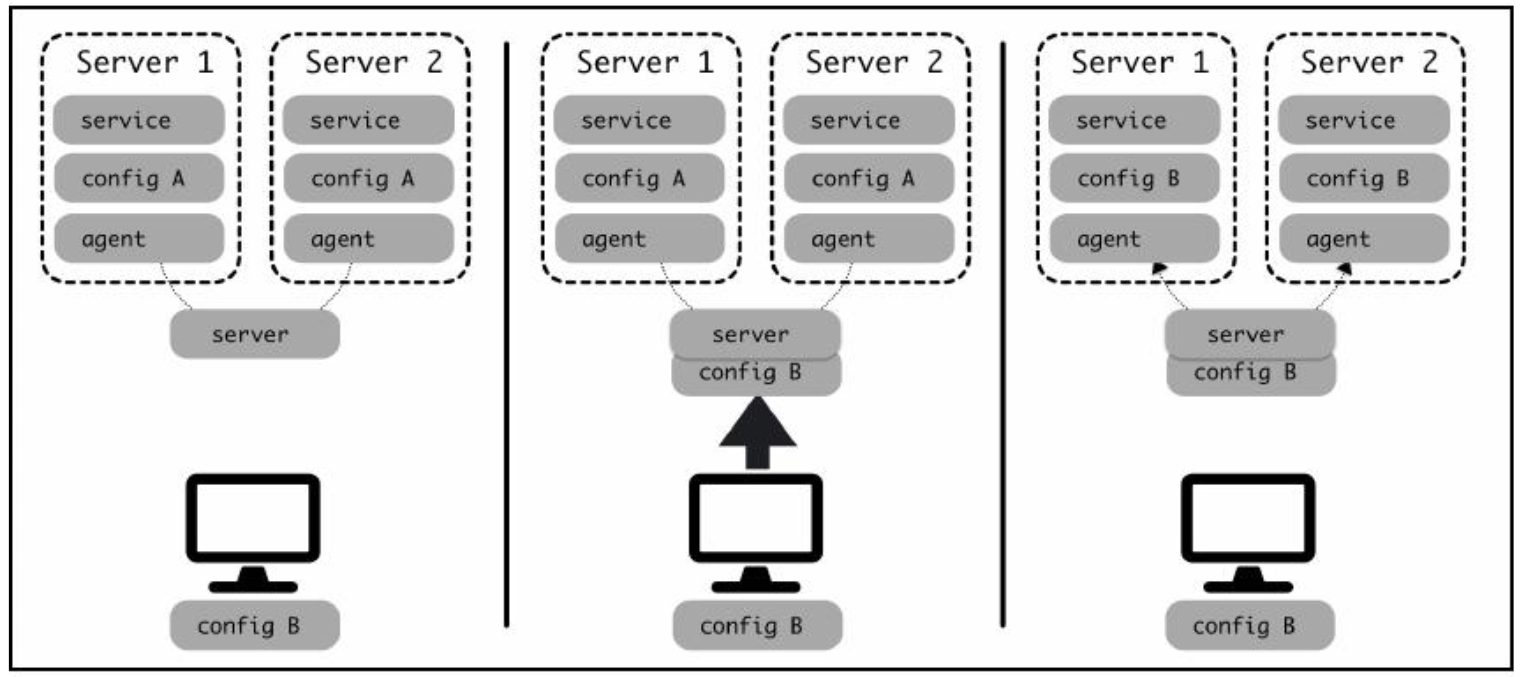

Dans certains cas, ces outils peuvent être en mesure d'allouer des ressources dans les services cloud ; par exemple, l'ajout d'une nouvelle instance EC2 dans AWS.


Toutes ces stratégies nécessitent des outils spécialisés et sont normalement gérées par une équipe opérationnelle spécifique. Cela rend la configuration hors de portée des développeurs nécessitant une coordination entre eux afin de faire une mise à jour de la configuration. Cette division du travail crée des frictions et, au fil du temps, le mouvement DevOps a proposé d'autres façons de structurer ce travail.

## Comprendre DevOps

La façon traditionnelle de diviser le travail consistait à créer une équipe d'exploitation qui contrôlera l'infrastructure et les déploiements, et une équipe de développement qui crée le service.


Le problème avec cette approche est que les développeurs ne comprendront normalement pas vraiment comment fonctionne leur code en production et, simultanément, les opérations ne sauront pas exactement ce que contient l'application. Cela peut conduire à des situations de je ne sais pas ce que c'est/je ne sais pas où c'est, où il y a un gouffre entre les deux équipes. DevOps a finalement été créé comme une approche pour combler cette lacune


    Un problème typique est celui où un service échoue fréquemment en
    production et est détecté par des opérations, qui effectuent des tactiques
    de correction (par exemple, redémarrer le service)

    Cependant, l'équipe de développement ne sait pas exactement ce qui le fait
    échouer et elle a d'autres priorités urgentes, elle ne résoudra donc pas le problème.



DevOps est un ensemble de techniques pour améliorer la collaboration entre le côté exploitation et le côté développement. Il vise à permettre un déploiement rapide en sensibilisant les développeurs à l'ensemble de l'opération, et à simplifier les opérations en utilisant autant que possible l'automatisation.

 L'essentiel est de donner aux équipes les moyens de contrôler leur propre infrastructure et leurs propres déploiements, en accélérant le taux de déploiement et compréhension de l'infrastructure pour aider à identifier les problèmes au plus tôt. 
 
 L'équipe doit être autonome dans le déploiement et le support de l'infrastructure. Pour activer les pratiques DevOps, vous avez besoin d'outils pour contrôler les différentes opérations de manière contrôlée. GitOps est un choix intéressant pour cela, surtout si vous utilisez Kubernetes.

## Définir GitOps 

L'idée de GitOps est simple : nous utilisons Git pour décrire notre infrastructure et la gestion de la configuration. Toute modification apportée à une branche définie déclenchera les modifications pertinentes. Si vous êtes capable de définir l'ensemble du système via du code, Git vous offre de nombreux avantages :

* Toute modification apportée à la gestion de l'infrastructure ou de la configuration est versionnée. Elles sont explicites et peuvent être annulées en cas de problème. Les changements entre les versions peuvent être observés via les différences, ce qui est une opération Git normale

* Un référentiel Git peut agir comme une sauvegarde qui peut permettre une récupération à partir de zéro en cas de défaillance catastrophique du matériel sous-jacent.

* C'est l'outil de contrôle de source le plus courant. Tout le monde dans l'entreprise sait probablement que cela fonctionne et peut l'utiliser. Il s'intègre également facilement aux workflows existants, comme les critiques.


Le concept GitOps a été présenté et nommé par Weaveworks dans un article de blog (https://www.weave.works/blog/gitops-operations-by-pull-request). Depuis lors, il est de plus en plus utilisé dans les entreprises. 

Bien que GitOps puisse être appliqué à d'autres types de déploiements (et il l'a certainement été), il présente une bonne synergie avec Kubernetes, ce qui était en fait la description dans le billet de blog Weaveworks.

 Un cluster Kubernetes peut être complètement configuré à l'aide de fichiers YAML, qui encapsulent presque toute la définition du système. Comme nous l'avons vu dans le chapitre précédent, cela peut inclure la définition d'éléments tels que les équilibreurs de charge. Les éléments externes au cluster Kubernetes, comme un DNS externe, qui ne sont pas inclus dans les fichiers YAML, sont rares à changer.


Comme nous l'avons vu au guide 6, Développement local avec Kubernetes, les fichiers YAML de Kubernetes contiennent des définitions d'éléments qui peuvent être appliquées avec les commandes kubectl apply -f <file>. Kubernetes est assez flexible car un seul fichier peut contenir plusieurs éléments ou un seul. Regrouper tous les fichiers YAML sous une structure de répertoires et les placer sous le contrôle de Git constitue un moyen très explicite d'appliquer les modifications. C'est ainsi que nous allons opérer. Cette opération n'est pas compliquée, mais nous allons utiliser un outil existant, créé par Weaveworks, appelé Flux

## La configuration de Flux pour contrôler le Kubernetes cluster

Flux (https://github.com/fluxcd/flux) est un outil qui garantit que l'état d'un cluster Kubernetes correspond aux fichiers stockés dans un référentiel Git. 

Il est déployé à l'intérieur du cluster Kubernetes, comme un autre déploiement. Il s'exécute toutes les 5 minutes et vérifie avec le référentiel Git et le registre Docker. Ensuite, il applique toutes les modifications. Cela facilite l'accès au référentiel Git, car il n'est pas nécessaire de créer de mécanisme de poussée à l'intérieur d'un système CI. 

Nous verrons comment démarrer un conteneur Flux dans Kubernetes qui extrait de GitHub repo.

## Démarrage du système

Pour plus de simplicité, nous utiliserons le Kubernetes local. Nous utiliserons les images décrites dans le guide 6, Développement local avec Kubernetes, assurez-vous donc d'exécuter les commandes suivantes :



    $ cd Local_Development_withKubernetes. 
    $ cd frontend
    $ docker-compose build server
    ...
    Successfully tagged thoughts_frontend:latest
    
    $ cd ..
    $ cd thoughts_backend/
    $ docker-compose build server db
    ...
    Successfully tagged thoughts_frontend:latest
    
    $ cd ..
    $ cd users_backend
    $ docker-compose build server db
    ...
    Successfully tagged users_server:latest


La configuration de base de Kubernetes est stockée dans le dossier exemple  example) sous-répertoire


Vous pouvez déployer l'ensemble du système avec les commandes suivantes :

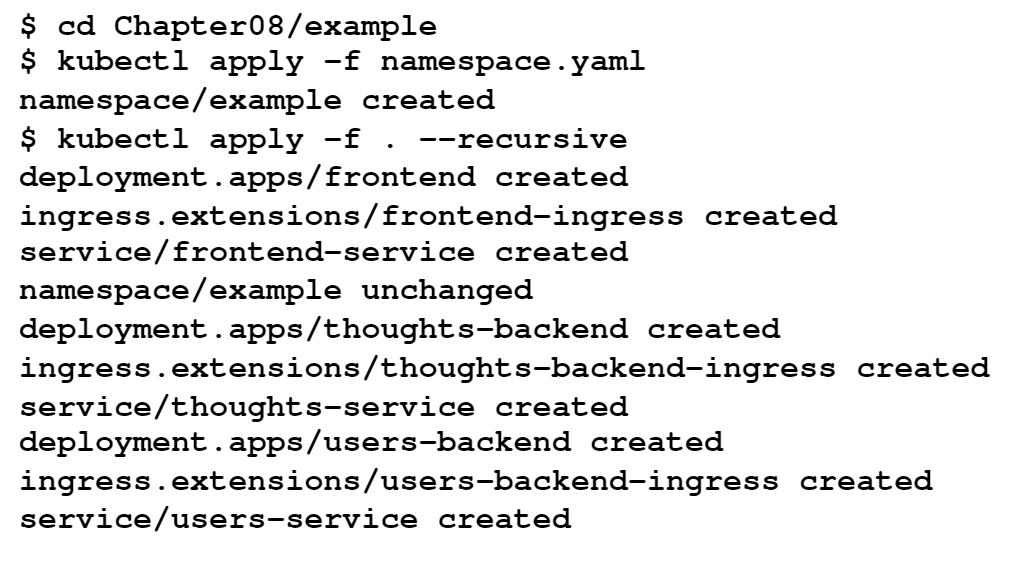

Cela crée l'intégralité du système. 


    Appliquez le fichier namespace.yaml pour éviter de ne pas pouvoir déployer
    des éléments car l'espace de noms n'est pas présent, mais vous pouvez
    exécuter le kubectlapply -f . --recursive commande deux fois.



Si vous vérifiez le système, il doit être déployé maintenant, comme illustré en exécutant la commande kubectlget pods :



    $ kubectl get pods -n example
    NAME                   READY STATUS  RESTARTS AGE
    frontend-j75fp         1/1   Running 0        4m
    frontend-n85fk         1/1   Running 0        4m
    frontend-nqndl         1/1   Running 0        4m
    frontend-xnljj         1/1   Running 0        4m
    thoughts-backend-f7tq7 2/2   Running 0        4m
    users-backend-7wzts    2/2   Running 0        4m


Notez qu'il existe quatre copies de frontend. Nous allons modifier le nombre de pods au cours de ce chapitre à titre d'exemple de la façon de modifier un déploiement. Maintenant, supprimez le déploiement pour recommencer à zéro :


    $ kubectl delete namespace example


## Configuration de Flux

Nous préparerons un système Flux, qui nous aidera à garder une trace de notre configuration Git. Nous en avons préparé un basé sur l'exemple Flux dans ce référentiel (https://github.com/fluxcd/flux/tree/master/deploy), et il est disponible dans le sous-répertoire Chapter08/flux.


Le fichier principal est flux-deployment.yaml. La plupart sont commentés, mais jetez un œil à la définition du référentiel à partir duquel extraire :


      # Replace the following URL to change the Git repository used by Flux.
      
      - --git-url=git@github.com:<votre repo gith>.git
      
      - --git-branch=master
      
      # Include this if you want to restrict the manifests considered by flux
      # to those under the following relative paths in the git repository
      
      - --git-path=votre dossier/example




Ces lignes indiquent à Flux le référentiel à utiliser, la branche et tout chemin. Si le chemin est commenté, ce qui est probablement le cas dans votre cas, il utilise l'intégralité du référentiel. Dans la section suivante, nous devrons modifier le référentiel pour utiliser le vôtre.


Pour utiliser Flux, créez l'espace de noms, puis appliquez le répertoire de flux complet :


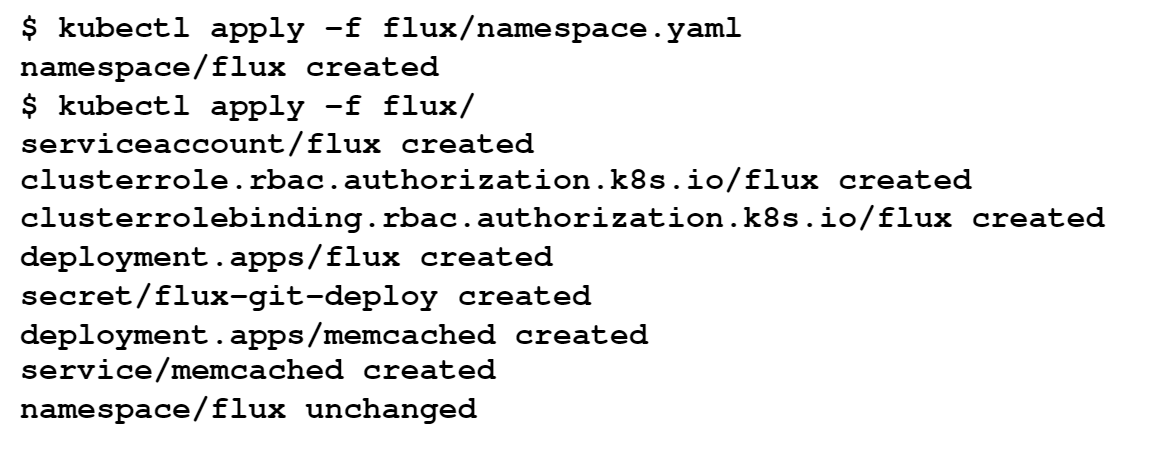


À l'aide du code suivant, vous pouvez vérifier que tout fonctionne comme prévu :


    $ kubectl get pods -n flux
    NAME                       READY STATUS  RESTARTS AGE
    flux-75fff6bbf7-bfnq6      1/1   Running 0        34s
    memcached-84f9f4d566-jv6gp 1/1   Running 0        34s


Mais, pour pouvoir déployer à partir d'un dépôt Git, nous devons le configurer.

## Configuration de GitHub

Bien que nous puissions configurer n'importe quel référentiel Git, nous utiliserons généralement GitHub pour le configurer. Nous devrons configurer une clé valide pour accéder au dépôt Git. 

Le moyen le plus simple de le faire est de permettre à Flux de générer sa propre clé et de l'ajouter au GitHubrepo. Mais pour pouvoir le faire, nous devons créer notre propre référentiel GitHub.

## Fork du repo GitHub

La première étape de la configuration du repo est de le forker. Examinons les étapes suivantes pour plus de détails :

* 1. Accédez à la page du dépôt GitHub pour le code (https://github.com/PacktPublishing/Hands-On-Docker-for-Microservices-with-Python/) et cliquez sur Fork dans le coin supérieur droit pour générer votre propre copie

* 2. Une fois que vous avez votre propre copie, elle aura une URL similaire à la suivante


    https://github.com/<YOUR GITHUB USER>/Hands-On-Docker-for-Microservices-with-Python/



* 3. Maintenant, vous devez le remplacer dans le fichier Chapter08/flux/flux-deployment.yaml pour le paramètre --git-url

* 4. Une fois que vous l'avez modifié, réappliquez la configuration de Flux avec la commande suivante


    $ kubectl apply -f flux/flux-deployment.yamldeployment.apps/flux changed


Désormais, Flux suit votre propre repo sous votre contrôle total et vous pouvez y apporter des modifications. Tout d'abord, nous devons autoriser Flux à accéder au référentiel GitHub, ce qui peut être réalisé via une clé de déploiement.



## Ajouter une clé de déploiement

Pour permettre à Flux d'accéder à GitHub, nous devons ajouter sa clé secrète en tant que clé de déploiement valide. En utilisant fluxctl, il est facile d'obtenir la clé ssh actuelle ; exécutez simplement la commande suivante :


    $ fluxctl identity --k8s-fwd-ns flux
    ssh-rsa <secret key>



Avec ces informations, allez dans settings | Deploy keys sur votre projet GitHub fork. Remplissez le titre avec un nom descriptif, la section Clé avec votre clé secrète obtenue auparavant, puis sélectionnez add key :

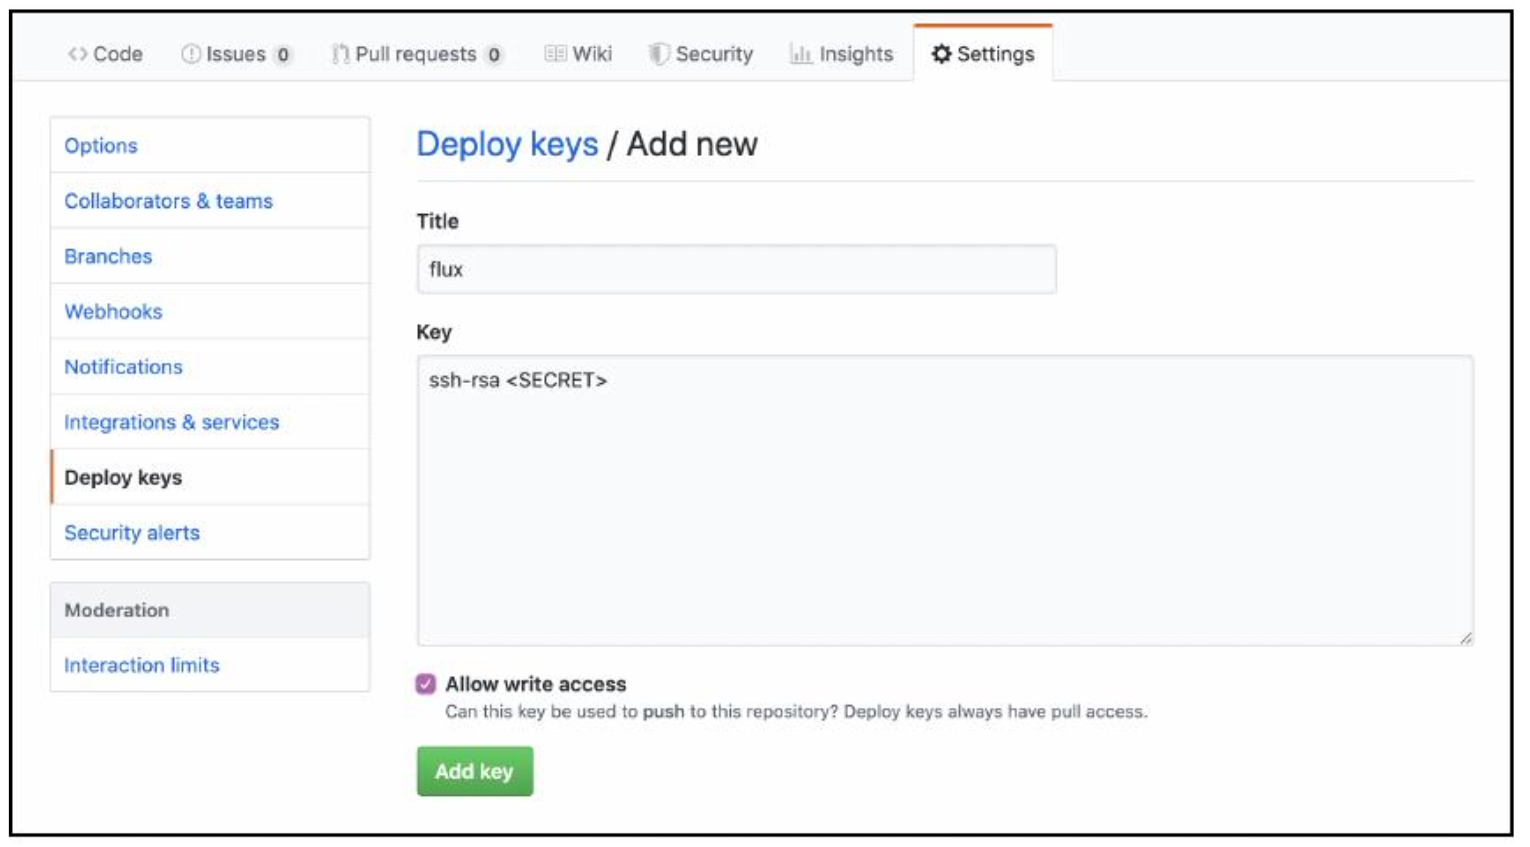

Assurez-vous de cocher la case Allow write access. Désormais, Flux pourra contacter GitHub. La prochaine étape consiste à synchroniser l'état sur GitHub et le cluster.

## Synchronisation de Flux

Nous pouvons synchroniser avec Flux, donc la description dans GitHub est appliquée dans le cluster, à l'aide de la commande suivante :

    $ fluxctl sync --k8s-fwd-ns flux


La synchronisation prendra un peu de temps et il est possible que vous obteniez une erreur indiquant qu'il est en train de cloner le dépôt :

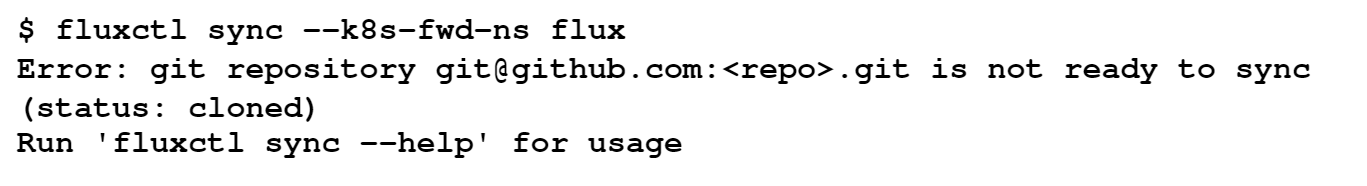
  


Attendez quelques minutes et réessayez :


      $ fluxctl sync --k8s-fwd-ns flux

  
Votre déploiement Flux et, par conséquent, le cluster Kubernetes local sont désormais synchronisés avec la configuration dans Git et seront mis à jour avec tout changement.

## Modification d'un cluster Kubernetes via GitHub

Votre cluster Kubernetes local, via Flux, sera mis à jour pour refléter les modifications apportées au référentiel Git. Toute modification dans Git sera propagée au cluster après quelques minutes. Voyons cela avec un test mettant à jour le nombre de pods dans le déploiement frontend :

* 1. Modifiez le fichier Chapter08/example/frontend/deployment.yaml dans votre référentiel forké comme décrit ici :


    ---
    apiVersion: apps/v1
    kind: Deployment
    metadata:
        name: frontend
        labels:
            app: frontend
        namespace: example
    spec:
        replicas: 2

Cela change le nombre de répliques de 4 à 2

* 2. Validez la modification dans la branche master et poussez dans le référentiel GitHub

* 3. Surveillez le cluster avec la commande suivante

    $ kubectl get pods -n example -w


Vous verrez comment le nombre de pods frontend diminuera après quelques minutes. Vous pouvez l'accélérer en synchronisant manuellement Flux.

* 4. Annulez la modification et voyez comment ils seront ajoutés


Toutes nos félicitations! Vous disposez maintenant d'un cluster contrôlé par un dépôt GitHub. Voyons quelques idées sur la façon d'utiliser efficacement cette méthodologie dans les environnements de production.









## Travailler en production

GitOps vise principalement à travailler sur des environnements de production, qui sont plus gros et plus complexes que l'exemple de cluster local que nous avons utilisé dans ce chapitre. 

Dans cette section, nous décrirons comment utiliser les avantages de Git pour améliorer la clarté en termes de déploiements et de changements, et comment être sûr de structurer les différents fichiers sous contrôle de source pour éviter toute confusion

## Création d'une structure

Structurer les fichiers YAML est essentiel pour un grand déploiement. Techniquement, vous pouvez tout joindre dans un seul fichier, mais ce n'est pas la meilleure façon de le gérer lorsqu'il grandit. Kubernetes offre une grande flexibilité, alors essayez de trouver une structure qui vous convient.


Une solution simple consiste à créer des sous-répertoires par espace de noms, puis par microservice. C'est ainsi que nous l'avons structuré dans cet exemple. Cette structure maintient les éléments liés ensemble et a un chemin clair pour toute personne touchant un microservice. Si les déploiements n'affectent qu'un seul microservice (comme ils le devraient, comme nous l'avons vu au chapitre 1, Faire le mouvement - Concevoir, planifier et exécuter, dans la section Déploiement parallèle et vitesse de développement), cela conserve les modifications dans le même sous-répertoire.


Mais ne vous sentez pas limité à cette structure. Si cela a du sens pour vous, vous pouvez essayer quelque chose de différent ; par exemple, faire une division par élément, c'est-à-dire tous les déploiements sous un répertoire, tous les services sous un autre, et ainsi de suite. N'ayez pas peur d'expérimenter et de déplacer des éléments, en recherchant la meilleure structure pour votre projet.Tous ces fichiers sont sous contrôle de source dans GitHub, ce qui nous permet d'utiliser leurs fonctionnalités à notre avantage

## Utiliser les fonctionnalités de GitHub

Étant donné que toute fusion avec la branche principale déclenchera un changement dans le cluster, cela doit être examiné avant d'être mis en ligne.

Vous pouvez le faire en exigeant une pull request qui doit être approuvée avant la fusion. L'approbation peut provenir d'une équipe Ops dédiée au suivi du cluster, ou du propriétaire du microservice ; par exemple, un chef d'équipe ou un gestionnaire


Un seul référentiel GitHub peut également suivre plusieurs environnements, par exemple, un environnement de mise en scène pour exécuter des tests et un environnement de production disponible pour les clients. Vous pouvez les diviser soit par branche, soit par sous-répertoire. Mais les fonctionnalités de GitHub ne sont pas les seules disponibles, la balise Git standard est extrêmement polyvalente et nous permet de définir des conteneurs spécifiques à déployer.






## Travailler avec des balises 

Dans cet exemple, nous avons travaillé avec la dernière balise pour les images. Cela utilise le conteneur le plus récemment construit, qui peut changer à chaque fois qu'une image est construite. Pour la production, nous devons utiliser une balise spécifique liée à un conteneur immuable, comme nous l'avons vu au chapitre 3, Créer, exécuter et tester votre service à l'aide de Docker, dans la section Utilisation d'un registre distant et dans le chapitre 4, Création d'un pipeline et d'un workflow, dans la section Pushing Docker de Travis CIsection


Cela signifie remplacer les lignes suivantes :


    spec:  
      containers:  
      - name: frontend-service    
      image: thoughts_frontend:latest


Nous les remplaçons par les suivants :



    spec:  
      containers:  
      - name: frontend-service    
      image: <registry>/thoughts_frontend:v1.5
  

C'est là que brille la possibilité de mettre à jour les images de manière contrôlée. Vous utiliserez le pipeline (comme décrit au chapitre 4, Création d'un pipeline et d'un flux de travail) pour créer et envoyer les images balisées vers le registre distant, puis vous pourrez contrôler quelle version spécifique est déployée dans le cluster.





